## Phase Diagram Simulation of Transformer Self-Attention Dynamics

In [1]:
import os
import sys
import time
import json
import pickle
import random
import string
import datetime
import contextlib
from types import SimpleNamespace

import torch
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../trafo-rotf-main")
from phase_diagrams_own import simu_xform, do_results, do_single_beta, plot_pickle

Using Metal backend


## Simulation Parameters

In [2]:
# Create arguments object (replaces argparse)
args = SimpleNamespace()

# Model dimensions
args.dmodel = 128  # dimensionality of each token
args.ntokens = 32  # number of tokens
args.batch = 2048  # number of batches

# Beta (temperature) range
args.betamin = 0.1  # lowest beta
args.betamax = 9.0  # largest beta
args.betas = 50  # total number of beta values

# Time evolution
args.maxtime = 30.0  # termination time
args.step = 0.1  # time step

# Attention mechanism
args.use_softmax = True  # use softmax normalization ( SUPER SLOW without softmax )

# Matrix configurations
args.randomV = 0  # V matrix: 0=identity, 1=random, 2=+KQ, 3=-KQ
args.randomKQ = 0  # KQ matrix: 0=identity, 1=random, 2=Wigner, 3=GOE

# Additional options
args.cluster_sizes = False  # compute cluster sizes
args.disable_tqdm = False  # disable progress bar
args.noanneal = 0  # 0=normal, 1=one KQV per beta, 2=one KQV per run
args.rawstep = False  # don't normalize step size
args.regen_period = 0.0  # regenerate KQV period (0=never)
args.plotdim = False  # plot dimension instead of clustering probability

print("Simulation parameters:")
for key, value in vars(args).items():
    print(f"  {key}: {value}")


Simulation parameters:
  dmodel: 128
  ntokens: 32
  batch: 2048
  betamin: 0.1
  betamax: 9.0
  betas: 50
  maxtime: 30.0
  step: 0.1
  use_softmax: True
  randomV: 0
  randomKQ: 0
  cluster_sizes: False
  disable_tqdm: False
  noanneal: 0
  rawstep: False
  regen_period: 0.0
  plotdim: False


## Device Setup

In [3]:
# Check for Metal availability
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Metal backend")
else:
    device = torch.device("cpu")
    print("Metal not available, using CPU")

# Set default tensor type
torch.set_default_dtype(torch.float32)
print(f"Default tensor type: {torch.zeros(1).dtype}")


Using Metal backend
Default tensor type: torch.float32


## Run Full Phase Diagram Simulation

In [4]:
# Generate output filename
salt = "".join(random.choices(string.ascii_letters + string.digits, k=3))
fname_prefix = datetime.datetime.now().strftime("ds_%Y_%m_%d-%H_%M_" + salt)

# Create directory for output files in plots folder
output_dir = os.path.join("..", "plots", fname_prefix)
os.makedirs(output_dir, exist_ok=True)

# Save args to a JSON file
args_file_path = os.path.join(output_dir, "args.json")
with open(args_file_path, "w") as f:
    # SimpleNamespace is not directly serializable, convert to dict
    json.dump(vars(args), f, indent=4)

print(f"Output will be saved to: {output_dir}")
print("Starting full phase diagram simulation...")
print(f"Beta range: {args.betamin} to {args.betamax} ({args.betas} values)")
print(f"Time range: 0 to {args.maxtime}")
print("This may take several minutes...")

Output will be saved to: ../plots/ds_2025_07_14-23_31_EpH
Starting full phase diagram simulation...
Beta range: 0.1 to 9.0 (50 values)
Time range: 0 to 30.0
This may take several minutes...


In [ ]:
start_time = time.time()
outdict = {"args": args}

# Run the simulation and capture printed output in a log file
log_file_path = os.path.join(output_dir, "simulation_output.log")
with open(log_file_path, "w") as log_file:
    with contextlib.redirect_stdout(log_file):
        main_res = do_results(args)
outdict.update(main_res)

# Save results
pickle_file = os.path.join(output_dir, fname_prefix + ".pkl")
with open(pickle_file, "wb") as f:
    pickle.dump(outdict, f)

end_time = time.time()

print(f"\nSimulation completed in {(end_time - start_time) / 60:.1f} minutes")
print(f"Results saved to: {pickle_file}")


Simu d=128, n=32, randomV=0:   0%|          | 0/50 [00:00<?, ?it/s]

Simu d=128, n=32, randomV=0: 100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


Simulation completed in 1.4 minutes
Results saved to: ds_2025_07_14-23_31_EpH.pkl


## Generate Phase Diagram Plots

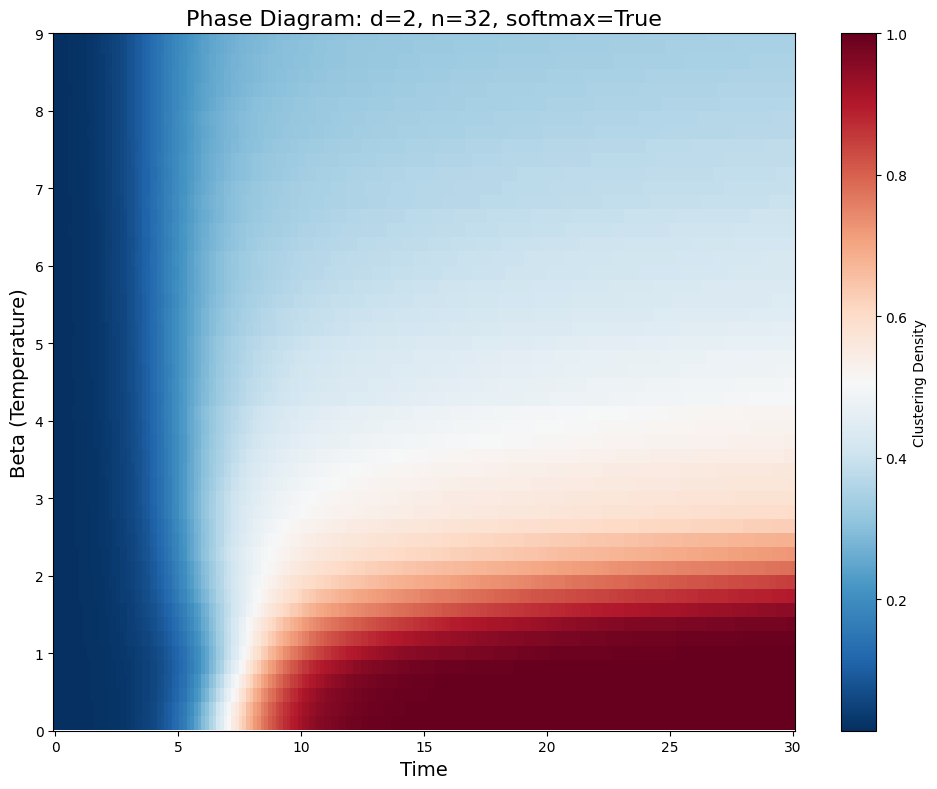

In [ ]:
with open(pickle_file, "rb") as f:
    results = pickle.load(f)

betas_list = results["betas_list"]
times_list = results["times_list"]
density_tensor = results["density_tensor"]
cluster_tensor = results["cluster_tensor"]

# Create inline phase diagram plot
Y = betas_list.reshape(-1, 1).expand(-1, times_list.shape[0])
X = times_list.reshape(1, -1).expand(betas_list.shape[0], -1)

plt.figure(figsize=(10, 8))
pc = plt.pcolormesh(X, Y, density_tensor, cmap="RdBu_r", linewidth=0, rasterized=True)
plt.colorbar(pc, label="Clustering Density")
plt.xlabel("Time", fontsize=14)
plt.ylabel("Beta (Temperature)", fontsize=14)
plt.title(
    f"Phase Diagram: d={args.dmodel}, n={args.ntokens}, softmax={args.use_softmax}",
    fontsize=16,
)
# make y-axis go from 0 to betamax
plt.ylim(0, args.betamax)
plt.tight_layout()

# Save to Output Dir
fname = f"phase_diagram_d={args.dmodel}.pdf"
filepath = os.path.join(output_dir, fname)
plt.savefig(filepath, dpi=300)

plt.show()

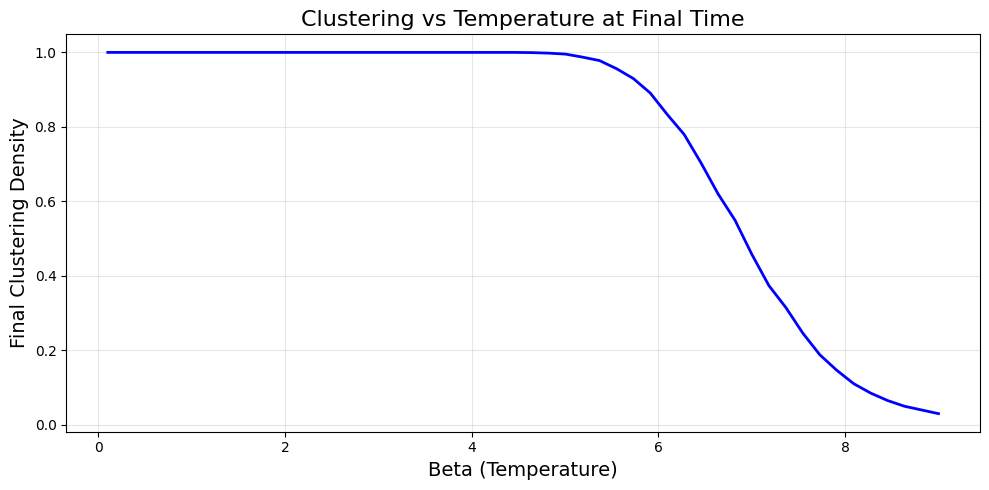

In [ ]:
# Show final state across beta values
plt.figure(figsize=(10, 5))
final_density = density_tensor[:, -1]  # Final time point
plt.plot(betas_list, final_density, "b-", linewidth=2)
plt.xlabel("Beta (Temperature)", fontsize=14)
plt.ylabel("Final Clustering Density", fontsize=14)
plt.title("Clustering vs Temperature at Final Time", fontsize=16)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Generate All Plots

In [ ]:
# folders = [
#     "ds_2025_07_14-21_40_xuU",
#     "ds_2025_07_14-23_21_mhA",
#     "ds_2025_07_14-23_24_wrB",
#     "ds_2025_07_14-23_31_EpH",
# ]

# for folder in folders:
#     fname_prefix = folder
#     # fname_prefix = "ds_2025_07_14-21_40_xuU"
#     output_dir = f"../plots/{fname_prefix}/"
#     pickle_file = os.path.join(output_dir, fname_prefix + ".pkl")

#     # Load results
#     with open(pickle_file, "rb") as f:
#         results = pickle.load(f)

#     # Also load args from json file
#     args_file = os.path.join(output_dir, "args.json")
#     with open(args_file, "r") as f:
#         args = json.load(f)

#     # Transform args to SimpleNamespace
#     args = SimpleNamespace(**args)

#     betas_list = results["betas_list"]
#     times_list = results["times_list"]
#     density_tensor = results["density_tensor"]
#     cluster_tensor = results["cluster_tensor"]

#     # Create inline phase diagram plot
#     Y = betas_list.reshape(-1, 1).expand(-1, times_list.shape[0])
#     X = times_list.reshape(1, -1).expand(betas_list.shape[0], -1)

#     plt.figure(figsize=(10, 8))
#     pc = plt.pcolormesh(
#         X, Y, density_tensor, cmap="RdBu_r", linewidth=0, rasterized=True
#     )
#     plt.colorbar(pc, label="Clustering Density")
#     plt.xlabel("Time", fontsize=14)
#     plt.ylabel("Beta (Temperature)", fontsize=14)
#     plt.title(
#         f"Phase Diagram: d={args.dmodel}, n={args.ntokens}, softmax={args.use_softmax}",
#         fontsize=16,
#     )
#     # make y-axis go from 0 to betamax
#     plt.ylim(0, args.betamax)
#     plt.tight_layout()

#     # Save to Output Dir
#     fname = f"phase_diagram_d={args.dmodel}.pdf"
#     filepath = os.path.join(output_dir, fname)
#     plt.savefig(filepath, dpi=300)

#     plt.show()